In [1]:
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice, AnalogDevice
from pulser.waveforms import InterpolatedWaveform
from pulser_simulation import QutipBackend
import matplotlib.pyplot as plt
import pickle

# import sys
# sys.path.append('../aquapointer/utils')
from aquapointer import benchmark_utils as bmu, density_utils as du, detuning_scale_utils as dsu

ModuleNotFoundError: No module named 'utils'

In [2]:
sys.path.append('../aquapointer/')
import qubo_solution, density_mapping, water_placement, processor

# Import stuff

In [3]:
# The 3D-RISM density slices are saved as pickled files in the folder MUP1.
# They are indexed by a number (see d_list) which represents the distance in Angstrom
# from the central slice.

d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]

# import slices
path = "../MUP1/MUP1_logfilter8_slices/"
basename = "_density_slice_MUP1_logfilter8.p"
densities = []
for d in d_list:
    filename = path + f"d{d}" + basename
    with open(filename, 'rb') as file_in:
         densities.append(pickle.load(file_in))
            
# import slice coordinates (these are 3D coordinates in
# angstroms, they are needed at the very end to map
# excited qubits to positions in the protein cavity)
path = "../MUP1/MUP1_logfilter8_points/"
basename = "_plane_points_MUP1.p"
points = []
for d in d_list:
    filename = path + f"d{d}" + basename
    with open(filename, 'rb') as file_in:
         points.append(pickle.load(file_in))


In [4]:
# The register associated to each slide can be found in the folder nb/registers.
# Two types of files are saved there:
# - position_<#>.npy: the positions of the qubits in micrometers, as if they were in the QPU
# - rescaled_position_<#>.npy: the positions of the qubits on the same scale as the density slices

# import registers
path = "../registers/"
basename = "position_"
positions = []
registers = []
for i in range(len(d_list)):
    with open(f'../registers/position_{i}.npy', 'rb') as file_in:
        pos = np.load(file_in)
    positions.append(pos)
    registers.append(Register.from_coordinates(pos)) # this is to create a Pulser register object

basename = "rescaled_position_"
rescaled_positions = []
for i in range(len(d_list)):
    with open(f'../registers/rescaled_position_{i}.npy', 'rb') as file_in:
        res_pos = np.load(file_in)
    rescaled_positions.append(res_pos)

Processing density 1 of 6
Density 1 has 4 qubits


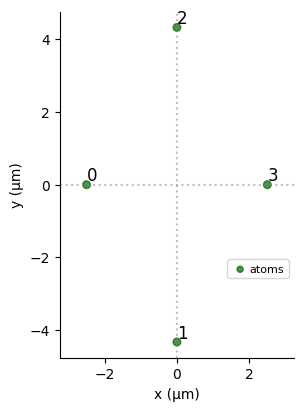

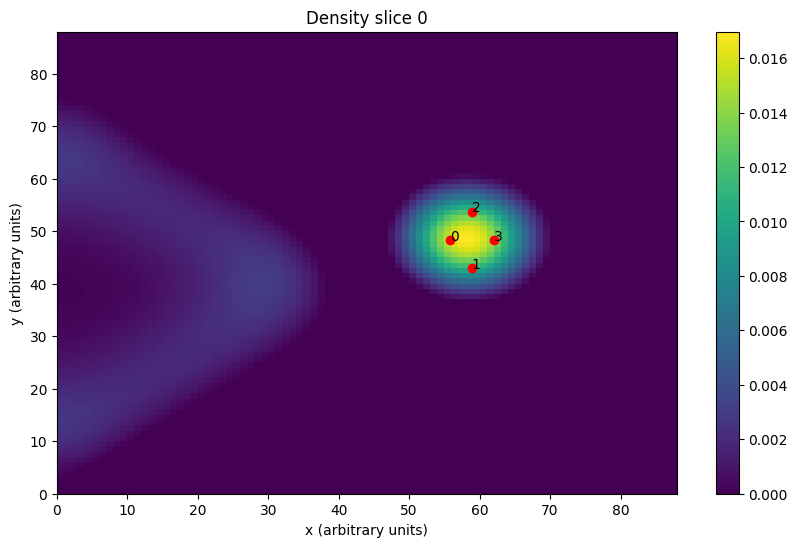

Processing density 2 of 6
Density 2 has 9 qubits


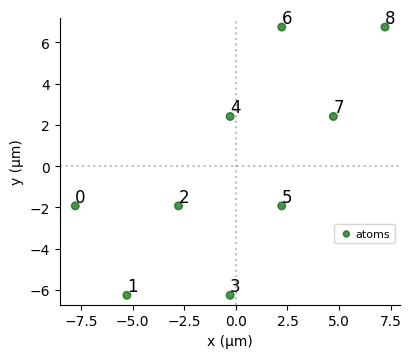

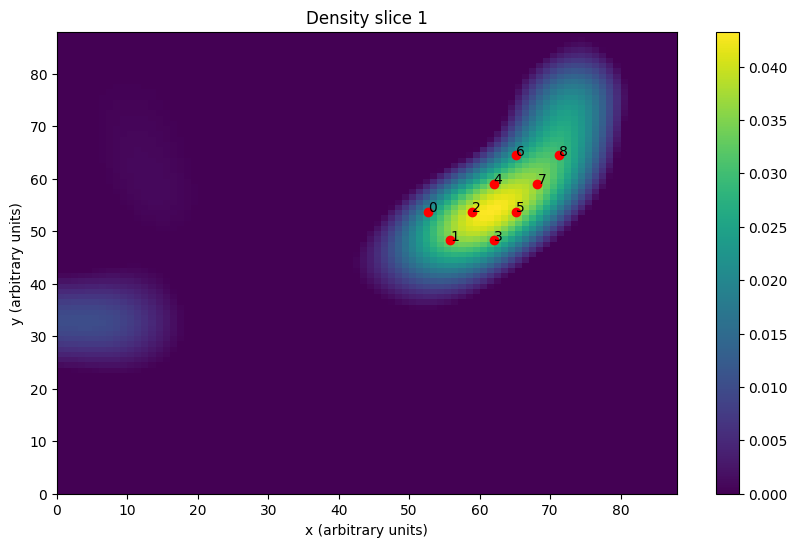

Processing density 3 of 6
Density 3 has 14 qubits


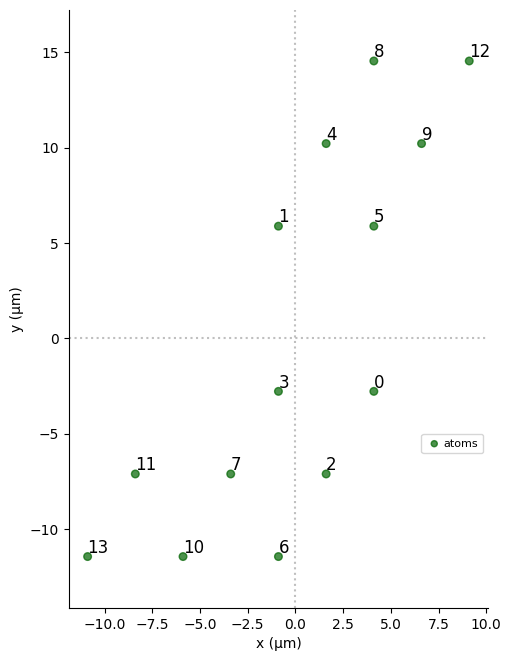

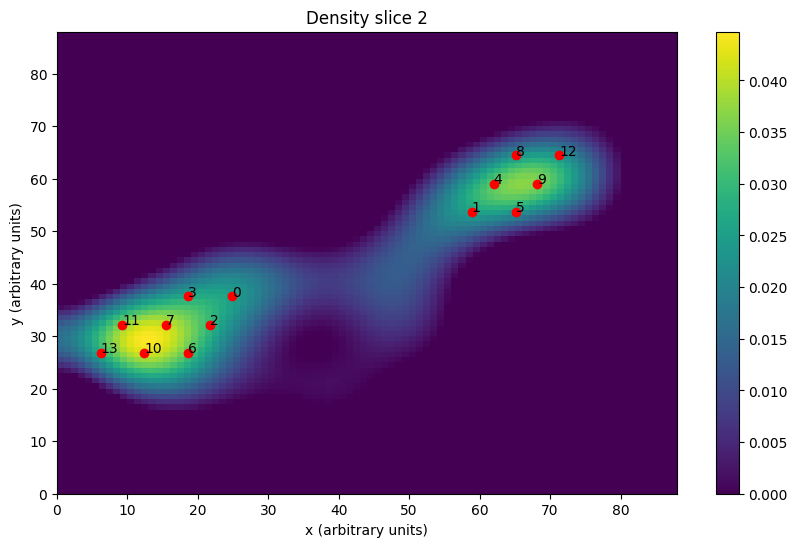

Processing density 4 of 6
Density 4 has 14 qubits


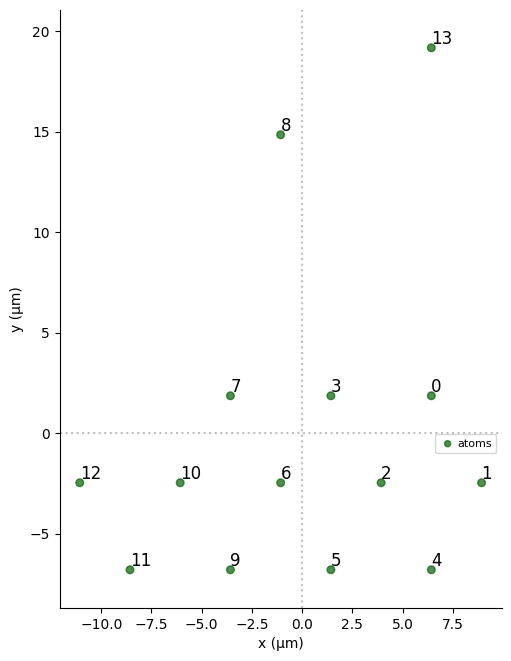

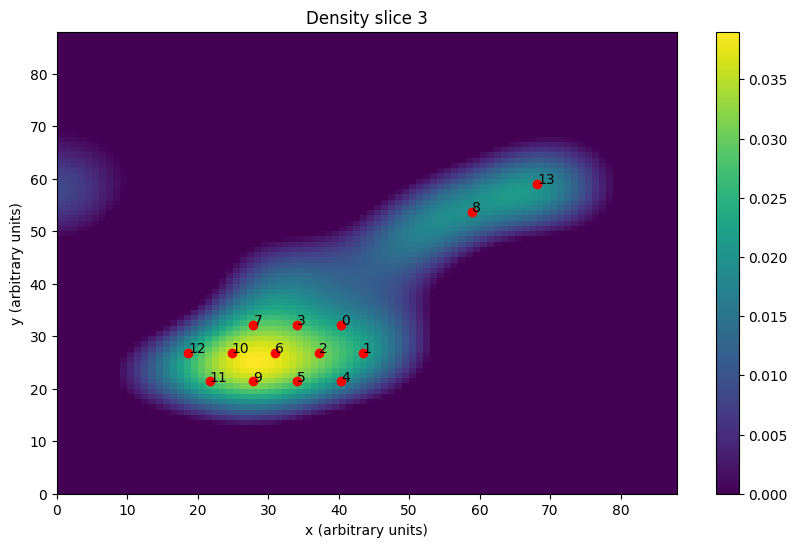

Processing density 5 of 6
Density 5 has 13 qubits


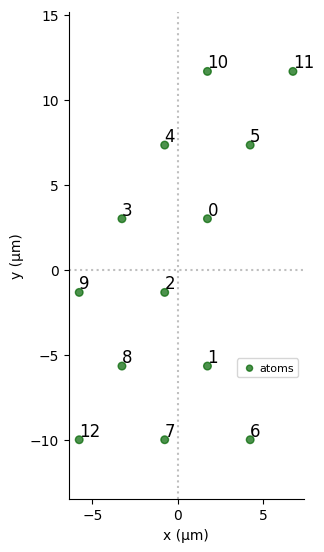

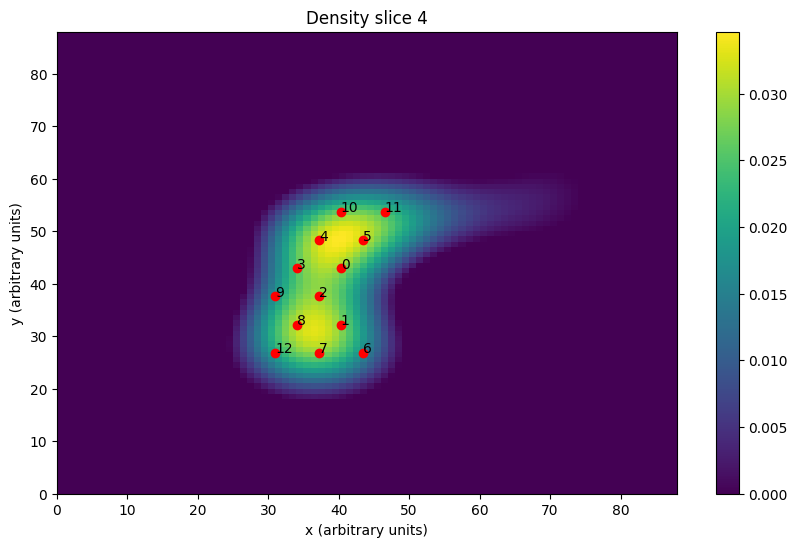

Processing density 6 of 6
Density 6 has 8 qubits


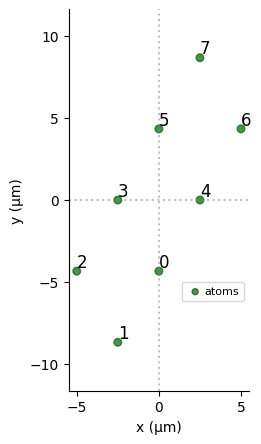

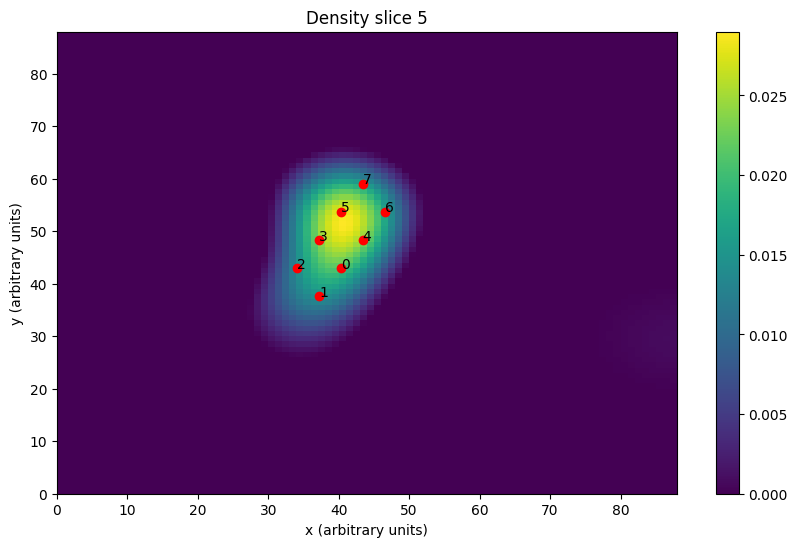

In [5]:
# Visualize registers and densities

for k, density in enumerate(densities):
    print(f"Processing density {k+1} of {len(densities)}")
    reg = registers[k]
    pos = positions[k]
    rescaled_pos = rescaled_positions[k]
    n = len(pos)
    print(f"Density {k+1} has {n} qubits")
    reg.draw()
    fig, ax = dsu.plot_density(density, rescaled_pos, title=f"Density slice {k}")

    plt.show()

# Parameter tuning

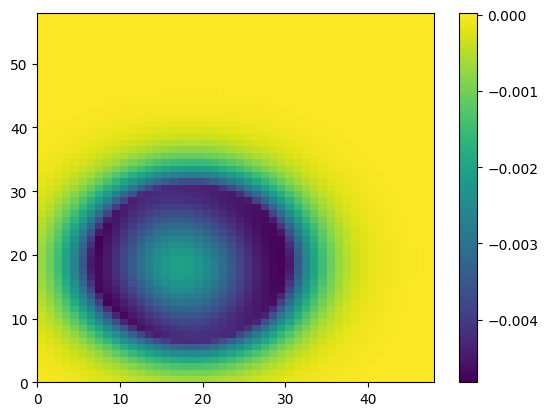

In [13]:
# The algorithm requires a choice of variance and amplitude for each Gaussian.
# We used a very heuristic method: take the first slice, and assume that it's composed
# of exactly one Gaussian. Given that assumption, we tried a bunch of values for
# variance and amplitude and chose the ones that worked best

variance = 50
amplitude = 6

G = amplitude*dsu.gaussian_mixture(densities[0].shape, variance, [(58,48.2)])
plt.pcolormesh((densities[0]-G)[30:,40:])
plt.colorbar()
plt.show()

In [7]:
variance, amplitude =  qubo_solution.fit_gaussian(densities[0])
(variance, amplitude)

(50, 6)

# Quantum solution

In [5]:
def executor(pulse_seq, num_samples):
    sim = QutipBackend(pulse_seq)
    res = sim.run()
    return res.sample_final_state(num_samples)

In [6]:
# choose the maximum detuning allowed (it's needed later)
max_det = AnalogDevice.channel_objects[0].max_abs_detuning-1

# choose a blockade radius (in micrometers)
# which in turns defines a Rabi frequency
brad = 7
omega = AnalogDevice.rabi_from_blockade(brad)

# choose a pulse duration
T = 3000

pulse_settings = processor.PulseSettings(brad=brad, omega=omega, pulse_duration=T, max_det=max_det)
processor_configs = [processor.AnalogProcessor(device=MockDevice, pos=pos, pos_id=p, pulse_settings=pulse_settings) for p, pos in enumerate(positions)]

In [16]:
best_solutions = []
samplings = []
for k, density in enumerate(densities):
    
    # print some stuff, unimportant
    print(f"Processing density {k+1} of {len(densities)}")
    reg = registers[k]
    pos = positions[k]
    rescaled_pos = rescaled_positions[k]
    n = len(pos)
    print(f"Density {k+1} has {n} qubits")
    # reg.draw()
    # fig, ax = dsu.plot_density(density, rescaled_pos)
    # # plt.show()
    
    # use function to calculate the one-body coefficients of the QUBO
    gamma_list = dsu.gamma_list(density, rescaled_pos, variance)
    
    # roundabout way of finding the scale factor between the QPU units
    # and the density units, it's needed in the next block
    distances_density = dsu.find_possible_distances(rescaled_pos)
    distances_register = dsu.find_possible_distances(pos)
    scale = distances_density[0]/distances_register[0]
    
    # test_gamma_list, test_scale = qubo_solution.calculate_one_body_qubo_coeffs(density, rescaled_pos, variance, pos)
    # print("test coeffs and scale")
    # print(test_gamma_list == gamma_list)
    # print(test_scale == scale)
    # calculate mapping between one-body coefficients of the QUBO
    # and detunings
    dets = np.array([item for item in gamma_list])
    for i in range(n):
        # this line shifts every value by a quantity that is the mean of neighbouring detunings
        # where a neighbour is defined as atoms whithin a blockade radius distance
        dets[i] -= np.mean(dsu.neighbouring_gamma_list(density, rescaled_pos, rescaled_pos[i], scale*brad, variance))
    # the next line line rescales every detuning so that the maximum one
    # turns out to be `max_det` (see first line of this cell)
    dets *= max_det/np.max(np.abs(dets))
    # test_dets =  qubo_solution.scale_detunings(density, pos, rescaled_pos, brad, variance, max_det)

    # print("test dets")
    # print(dets == test_dets)

    # test_seq = qubo_solution.generate_pulse_sequences(MockDevice, reg, dets, max_det, T, omega)
    # Pulser stuff begins --------------------------
    seq = Sequence(reg, MockDevice)
    for i in range(n):
        # add an adiabatic pulse for every qubit
        seq.declare_channel(f'ch{i}', 'rydberg_local')
        seq.target(i, f'ch{i}')
        pulse = Pulse(InterpolatedWaveform(T, [0, omega, 0]), InterpolatedWaveform(T, [-max_det, 0, dets[i]]), 0)
        seq.add(pulse, f'ch{i}')
    # uncomment next line if you want to visualize the pulse sequence
    # # seq.draw()
    # print("test sequences")
    # print(test_seq.to_abstract_repr() == seq.to_abstract_repr())
    

    # # run simulation
    sim = QutipBackend(seq)
    res = sim.run()
    samples = res.sample_final_state(1000)
    # # Pulser stuff ends ----------------------------

    # num_samples = 1000
    # print("test qubo flow")
    # # test_best_solution = qubo_solution.run_qubo(density, executor, MockDevice, reg, rescaled_pos, pos, variance, amplitude, brad, T, omega, max_det)
    # test_best_solution = qubo_solution.run_qubo(density, executor, processor_configs[k], rescaled_pos, pos, variance, amplitude)
    # The next block calculates the cost (from the QUBO) of each
    # bitstring sampled with the analog algorithm 
    quantum_solutions = sorted(samples.items(), key=lambda x: x[1], reverse=True)
    quantum_plus_classical_solutions = []
    for bitstring, count in quantum_solutions:
        # calculate QUBO cost of bitstring
        ising = dsu.ising_energies(rescaled_pos, density, variance, [bitstring], brad, amp=amplitude)
        # the next try-except block is needed because the QUBO cost calculated in the line above
        # resturns empty whenever the blockade constraint is not respected
        try:
            i_bit = ising[0][0]
            i_en = ising[0][1]
            quantum_plus_classical_solutions.append((bitstring, count, i_en)) 
        except IndexError:
            i_bit = bitstring
            i_en = 1e10
            quantum_plus_classical_solutions.append((bitstring, count, i_en)) 
        # print(bitstring, count, i_en)
    # print the best solution, which is defined as the bitstring sampled with the analog algorithm
    # that has the lowest cost in the QUBO
    best_solution = sorted(quantum_plus_classical_solutions, key=lambda x: x[2], reverse=False)[0][0]
    best_solutions.append(best_solution)
    samplings.append(np.array(quantum_plus_classical_solutions, dtype=object))
    print("The best solution is: ", best_solution)
    # print(test_best_solution == best_solution)
    # test_best_solution =  qubo_solution.best_solution_from_samples(samples, rescaled_pos, density, brad, variance, amplitude)
    # print("The best solution according to best_solution_from_samples is:", test_best_solution)
    print()

Processing density 1 of 6
Density 1 has 4 qubits
The best solution is:  1000

Processing density 2 of 6
Density 2 has 9 qubits
The best solution is:  010000001

Processing density 3 of 6
Density 3 has 14 qubits
The best solution is:  00001001000000

Processing density 4 of 6
Density 4 has 14 qubits
The best solution is:  00000010100000

Processing density 5 of 6
Density 5 has 13 qubits
The best solution is:  0000010100000

Processing density 6 of 6
Density 6 has 8 qubits
The best solution is:  00010000



# Visualize results

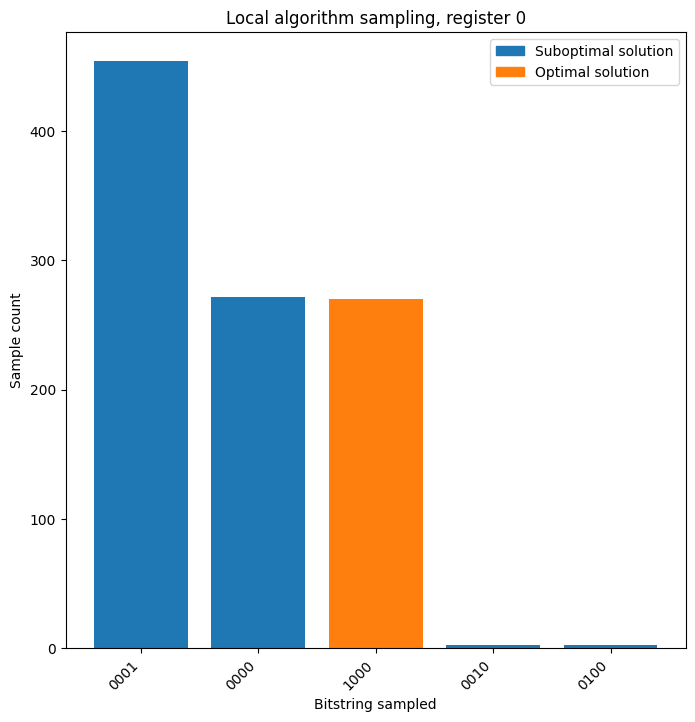

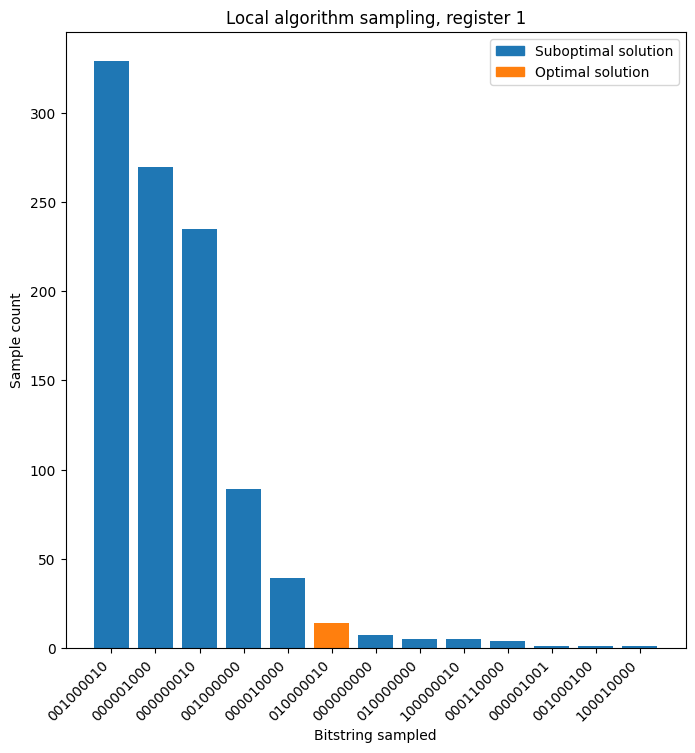

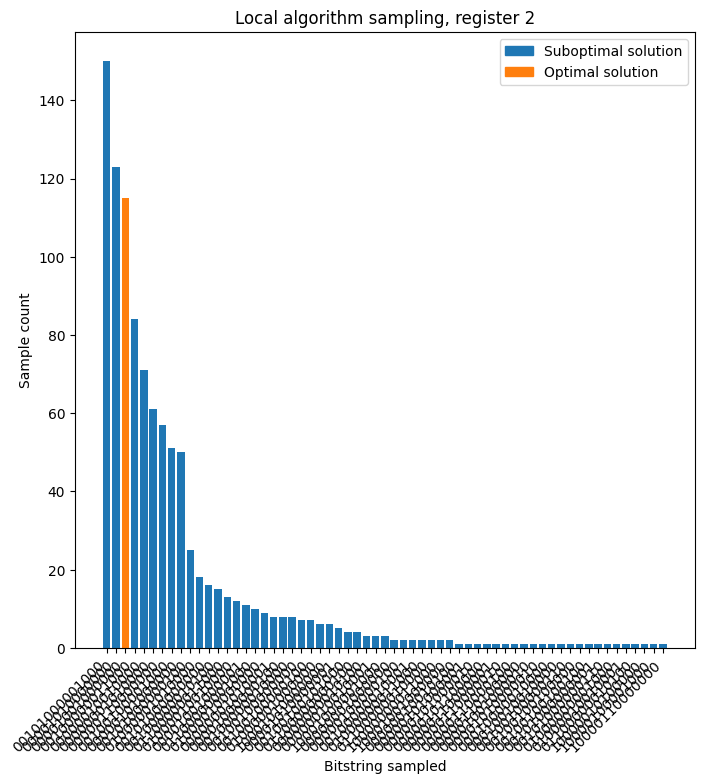

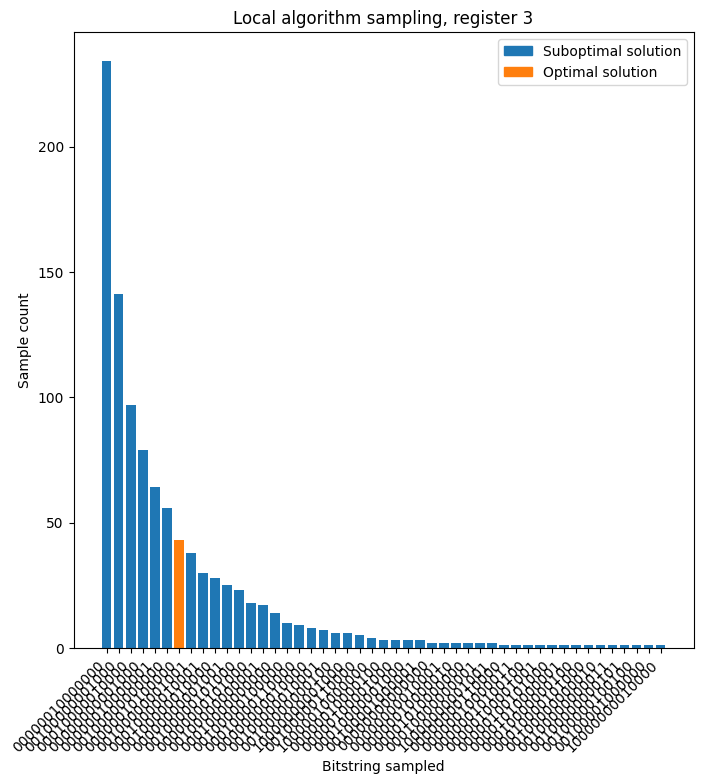

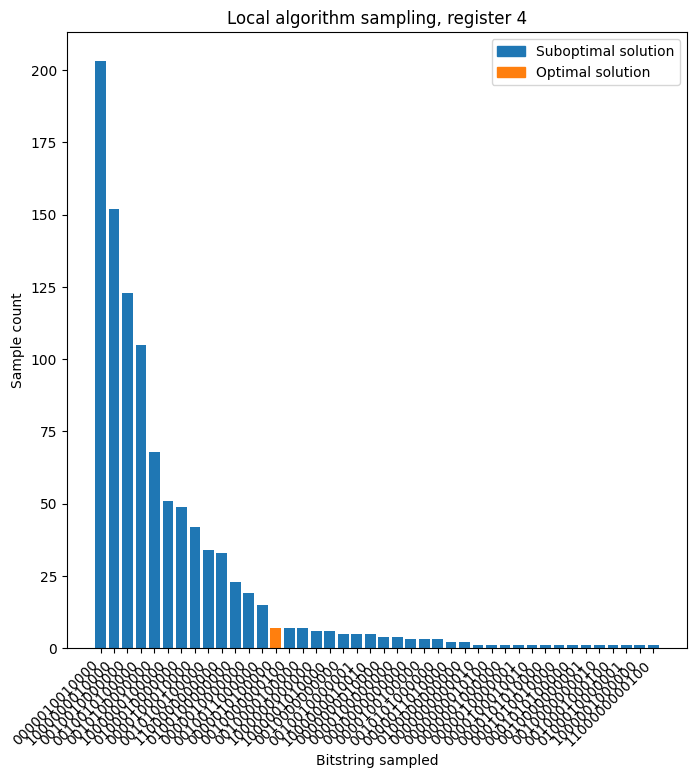

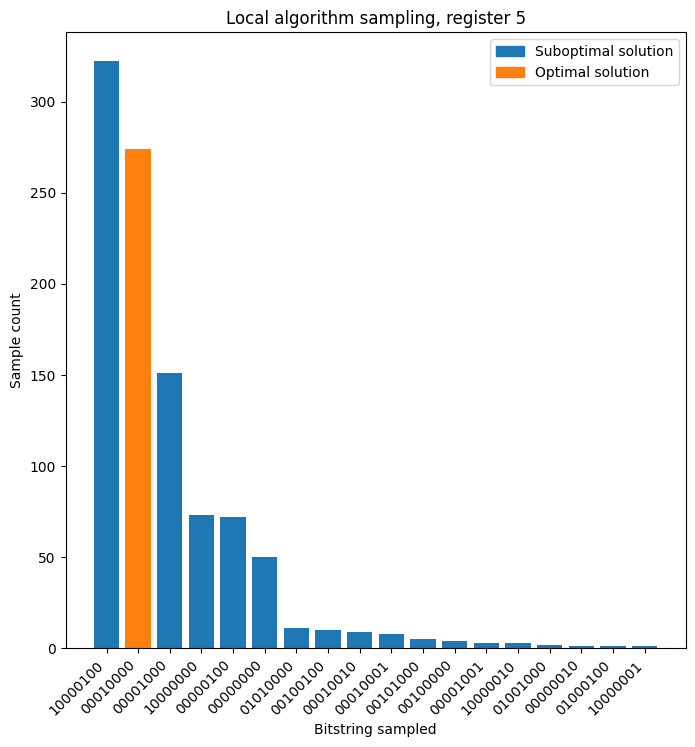

In [10]:
for i in range(len(samplings)):
    plt.figure(figsize=(8,8))
    plt.xlabel("Bitstring sampled")
    plt.ylabel("Sample count")
    plt.title(f"Local algorithm sampling, register {i}")
    plt.xticks(rotation=45, ha='right')
    colors = ['tab:blue' if item != best_solutions[i] else 'tab:orange' for item in samplings[i][:,0]]
    plt.bar(samplings[i][:,0], samplings[i][:,1], color=colors)
    colors = {'Suboptimal solution':'tab:blue', 'Optimal solution':'tab:orange'}         
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.legend(handles, labels)
    plt.show()
    

# Remap bitstrings to water molecule positions in the protein cavity

In [11]:
# This next section is a bit convoluted, and that's because we are working with different objects
# at different scales:
# There's the qubit register, in micrometers
# There's the 2D density slices, in some arbitrary unit (they are 2D arrays with size 88x88)
# There's the positions of the qubits, rescaled to the same units of the 2D density slices
# And finally there's the full 3D density, in angstroms.
# The purpose of the next few cells is to go from the qubits (in micrometers), to positions
# in the protein cavity as 3D vectors (in angstroms).

In [17]:
# for each solution, find index of excited qubits
qubit_indices = []
for bitstring in best_solutions:
    ls = []
    for i,b in enumerate(bitstring):
        if b=='1':
            ls.append(i)
    qubit_indices.append(ls)

In [18]:
# from their indices, find positions of excited qubits
# (on the scale of the density slices, not in micrometers)
qubit_rescaled_positions = []
for i,indices in enumerate(qubit_indices):
    ls = []
    for idx in indices:
        ls.append(rescaled_positions[i][idx])
    qubit_rescaled_positions.append(ls)

In [19]:
# from the rescaled positions, find the indices on the 3D map
water_indices = []
for i,res_pos in enumerate(qubit_rescaled_positions):
    ls = []
    for pos in res_pos:
        ls.append((int(pos[1]), int(pos[0])))
    water_indices.append(ls)

In [14]:
test_water_indices = density_mapping.rescaled_positions_to_3d_map(best_solutions, rescaled_positions)
print(test_water_indices == water_indices)

True


In [20]:
# and finally from the indices find the water molecule positions
# in angstroms
water_positions = []
for i,slice in enumerate(water_indices):
    ls = []
    for idx_i, idx_j in slice:
        ls.append(points[i][idx_i,idx_j])
    water_positions.append(ls)

In [34]:
densities[0].shape

(88, 88)

In [43]:
np.array([[1,2], [3,4]]).flatten()

array([1, 2, 3, 4])

In [46]:
densities[0].flatten().shape

(7744,)

In [48]:
list(range(densities[0].shape[0])) * densities[0].shape[1]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,


In [18]:
import itertools
list(itertools.chain.from_iterable([[d] * densities[0].shape[1] for d in range(densities[0].shape[1])]))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [7]:
test_water_postions = water_placement.find_water_positions(densities, points, executor, processor_configs)
test_water_postions

[array([24.331302  , 16.37638359, 32.70407856]),
 array([24.331302  , 15.95704731, 32.97639654]),
 array([24.07561299, 16.51974763, 33.842886  ]),
 array([24.37951925, 15.98075744, 33.93095164]),
 array([25.77148983, 14.29863619, 31.34069132]),
 array([24.74137793, 14.03285874, 31.84947105]),
 array([24.36242821, 15.3161336 , 33.82555688]),
 array([24.93911452, 14.45973064, 33.4248458 ]),
 array([24.43747167, 13.73317637, 32.30604137]),
 array([25.24302078, 13.92074045, 33.51291144])]

In [8]:
test_water_postions

(array([[49.31629005, 15.87979795, 38.17075504],
        [50.14745903, 13.60733645, 37.17329492],
        [52.23535787, 13.86505467, 36.57946971],
        [48.79804268, 16.01881472, 39.49992075],
        [51.16422189, 13.49861796, 39.11478903],
        [49.37937872, 14.85169822, 39.47969497],
        [49.53148175, 13.31674144, 37.70618363],
        [50.54824461, 14.0212642 , 39.01200271],
        [49.31629005, 15.47317732, 38.48859256],
        [49.41401996, 15.49616848, 39.60270707]]),
 0.0)